\begin{center}
Chun-Yuan (Scott) Chiu
\end{center}
\begin{center}
chunyuac@andrew.cmu.edu
\end{center}

## 1. {-}

Read in the data and drop the ```id``` and ```bond_id``` columns which clearly have no predictive power. Those columns that have "type" in the column name and the ```is_callable``` column are categorical variables which should be converted into dummy variables. Any other columns are on ratio scale. There are 46 of them. After the conversion, including the dummy variables, there are 69 predictors in the data (note that the response ```trade_price``` is also in the data now). We then add a constant column with value 1 for intercept in the regression. 

In [1]:
import pandas as pd

data = pd.read_csv('bonddata.txt', sep=',').drop(['bond_id', 'id'], axis='columns')

# categorical
catCols = ['is_callable'] + [col for col in data.columns if 'type' in col]

# predictors on ratio scale
rsCols = [col for col in data.columns if col not in ['is_callable', 'trade_price'] and 'type' not in col]

data = pd.get_dummies(data=data, columns=catCols, drop_first=True)
data['constant'] = 1

print(len(rsCols))
print(data.shape)

46
(1620, 71)


Below we plot the histogram for the first few predictors that are on ratio scale. The skewness for some of the variables is clear

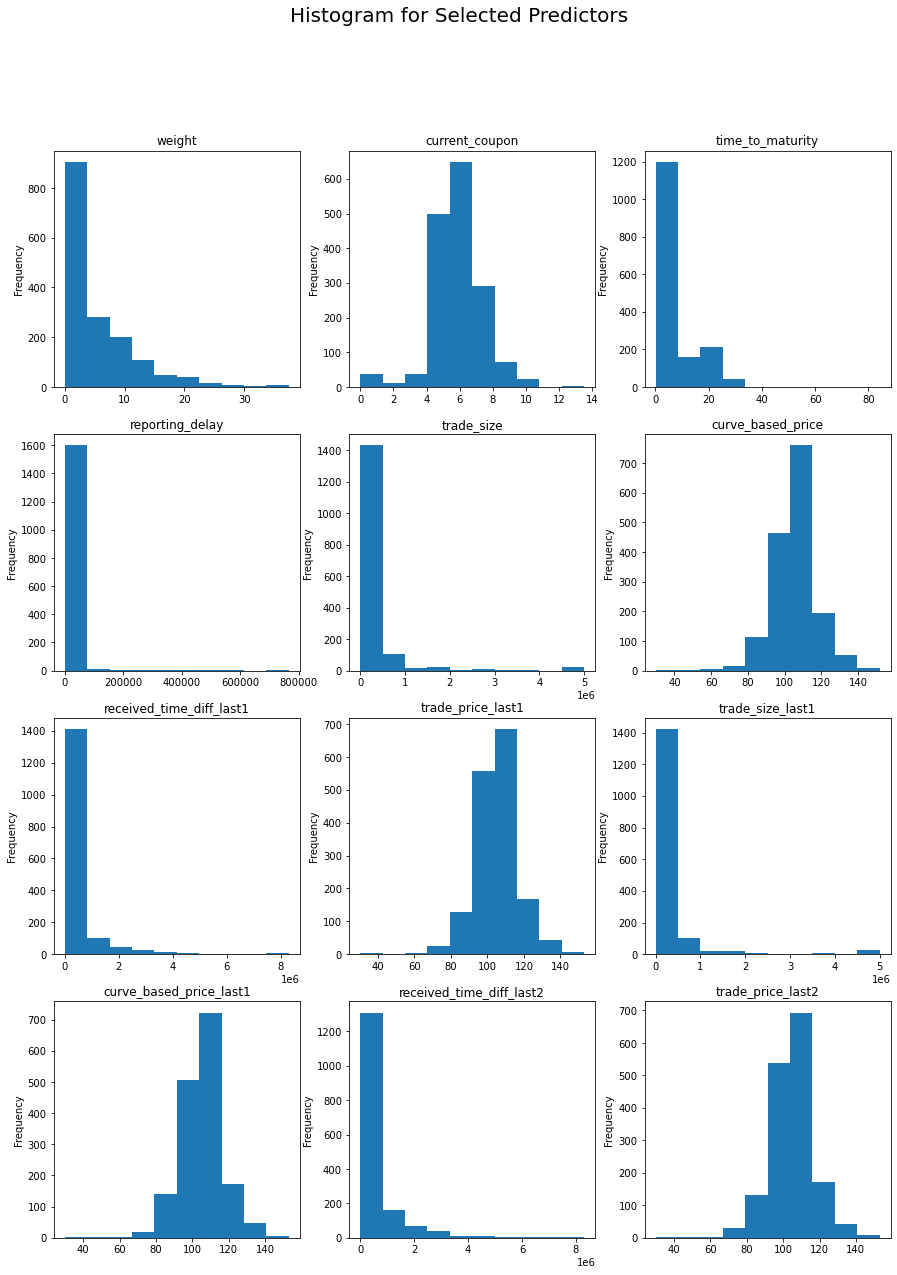

In [2]:
import matplotlib.pyplot as plt

def histplotGrid(suptitle):
    fig, axs = plt.subplots(4, 3, figsize=(15, 20))
    fig.suptitle(suptitle, size=20)

    for col, ax in zip(rsCols[:12], axs.flatten()):
        data[col].plot(kind='hist', ax=ax)
        ax.set_title(col)
        
histplotGrid('Histogram for Selected Predictors')

We then apply the Yeo-Johnson transformation on each of those 46 predictors. The ```trade_size``` columns and the ```received_time_diff``` columns have large values so a $\log(1+x)$ transformation is applied beforehand. The histogram of the first few predictors after transformation are shown below.

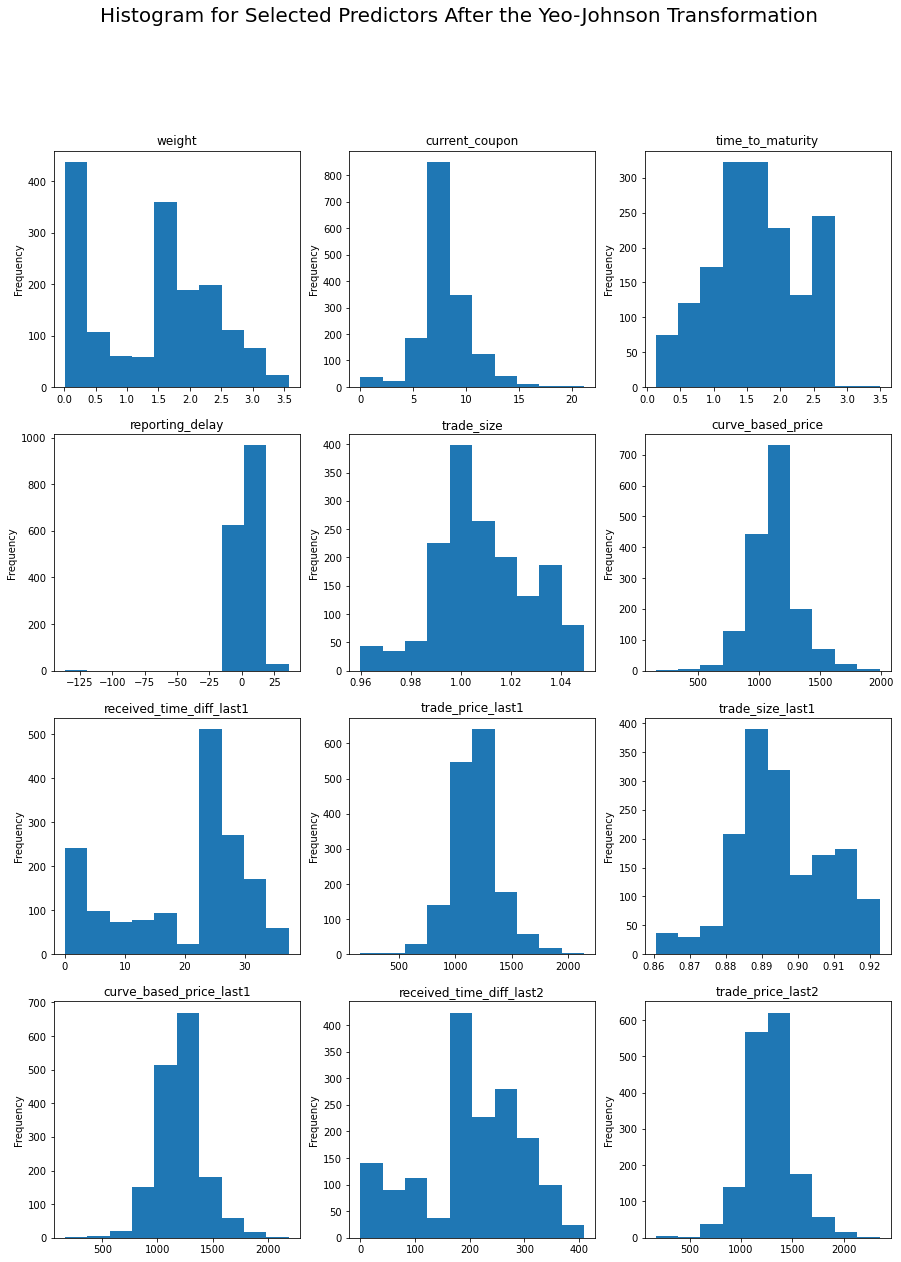

In [3]:
from scipy import stats
import numpy as np

lambdaDict = {}
for col in rsCols:
    if 'received_time_diff' in col or 'trade_size' in col:
        data[col] = np.log(data[col] + 1)
    data[col], lambdaDict[col] = stats.yeojohnson(data[col])

histplotGrid('Histogram for Selected Predictors After the Yeo-Johnson Transformation')

Convert all dummy variables to float so that rpy2 can work. 

In [4]:
for col in data.columns:
    if 'type' in col or 'is_callable' in col:
        data[col] = data[col].map(float)

The ```boxcox``` R procedure shows that the optimal $\lambda$ for the response is 1.6. 

In [5]:
import rpy2
%load_ext rpy2.ipython

[1] 1.59596


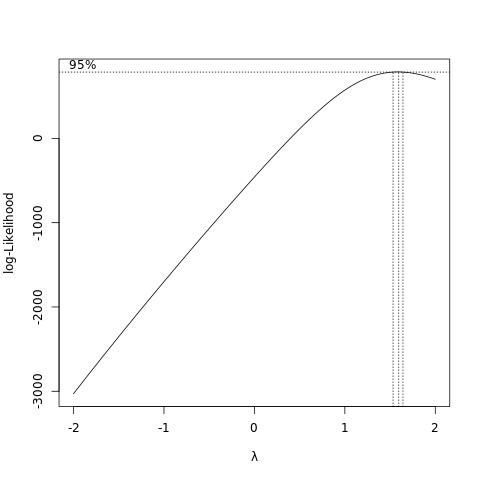

In [6]:
%%R -i data

library(MASS)
res = boxcox(trade_price~., data=data)
res$x[which(res$y==max(res$y))]

Now we fit the model $y^{1.6} = \sum\beta_i x_i$. Note that, with $\lambda=1.6$, the Box-Cox transformation $y^{(1.6)}$ is merely a linear function of $y^{1.6}$, so using either as the response is equivalent. 

In [7]:
# data = data.drop('reporting_delay', axis='columns')

In [8]:
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import norm

model = sm.OLS(endog=(data['trade_price']**(1.6)), exog=data.drop('trade_price', axis='columns')).fit()

# qqplot(model.resid, dist=norm, line='45', fit=True)



# plt.scatter(model.fittedvalues, model.resid)
# plt.xlabel('Fitted Values')
# plt.ylabel('Residuals')
# plt.show()


In [9]:
model.params.to_dict()

{'weight': 4.3274681552774865,
 'current_coupon': 0.46117258497316205,
 'time_to_maturity': -0.33717145540204996,
 'reporting_delay': -0.6267526549779516,
 'trade_size': 413.2111087949995,
 'curve_based_price': 0.5760482993292471,
 'received_time_diff_last1': -0.28786093686101655,
 'trade_price_last1': 0.6073344999069747,
 'trade_size_last1': -320.40188362862455,
 'curve_based_price_last1': 0.008038837870656401,
 'received_time_diff_last2': -0.010882015888203506,
 'trade_price_last2': 0.047442016210634486,
 'trade_size_last2': 72.20007998845495,
 'curve_based_price_last2': -0.08728093019427763,
 'received_time_diff_last3': 0.0067414143849305955,
 'trade_price_last3': 0.07106490716776026,
 'trade_size_last3': -67.01242406636811,
 'curve_based_price_last3': -0.1626297075300034,
 'received_time_diff_last4': -0.0032113571780007302,
 'trade_price_last4': 0.09841580086454538,
 'trade_size_last4': -110.57997511844837,
 'curve_based_price_last4': 0.2949305237436789,
 'received_time_diff_last5'

In [10]:
from pandas import DataFrame
import hvplot.pandas

DataFrame({'fitted': model.fittedvalues, 'resid': model.resid}).hvplot(kind='scatter', x='fitted', y='resid')

:Scatter   [fitted]   (resid)

In [11]:
ss = model.params
ss.name = 'params'
df = data.iloc[1456].to_frame().merge(ss, left_index=True, right_index=True)
df[1456] @ df['params']


2181.1333537029295

In [12]:
# fig, axs = plt.subplots(9, 5, figsize=(15, 30))

# for col, ax in zip(rsCols, axs.flatten()):
#     data.iloc[1450:1600][col].plot(kind='hist', ax=ax)
#     ax.set_title(col)


# data.iloc[1450:1550].plot(kind='hist')